# Idealized examples showing proof of concept

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import cmocean
import xarray as xa

import sys,os
testdir = os.path.dirname(os.getcwd() + '/')
srcdir = '..'
sys.path.insert(0, os.path.abspath(os.path.join(testdir, srcdir)))
from ocean_wave_tracing import Wave_tracing

%matplotlib inline

In [2]:
# READ INPUT DATA
ncin = xa.open_dataset('idealized_input.nc')
idt0=15 #22

# Current forcing

In [91]:
X = ncin.x.data
Y = ncin.y.data
nx = len(X)
ny = len(Y)
dx=dy=X[1]-X[0]
nb_wave_rays = 200#550#nx
T = 3000
nt = 190 # 1500
wave_period = 10 #s
X0, XN = X[0], X[-1] 
Y0, YN = Y[0], Y[-1]

i_w_side = 'left'
theta0=0

In [81]:
# EDDY
wt_eddy = Wave_tracing(ncin.U[idt0::,:,:], ncin.V[idt0::,:,:], nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     )
wt_eddy.set_initial_condition(wave_period, theta0,incoming_wave_side=i_w_side)
wt_eddy.solve()

In [82]:
# Jet
wt_jet = Wave_tracing(ncin.U_jet[:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy,nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     )
wt_jet.set_initial_condition( wave_period, theta0, incoming_wave_side=i_w_side)
wt_jet.solve()
ds_jet_left=wt_jet.to_ds()



In [83]:
#Opposing jet
wt_jet_o = Wave_tracing(ncin.U_jet[:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy,nb_wave_rays=nb_wave_rays,
                     domain_X0=X0, domain_XN=XN,
                     domain_Y0=Y0, domain_YN=YN,
                     )
wt_jet_o.set_initial_condition( wave_period, np.pi,incoming_wave_side='right')
wt_jet_o.solve()
ds_jet_right=wt_jet_o.to_ds()

In [84]:
vorticity = wt_eddy.dvdx-wt_eddy.dudy


In [85]:
#plotting params
fs=15

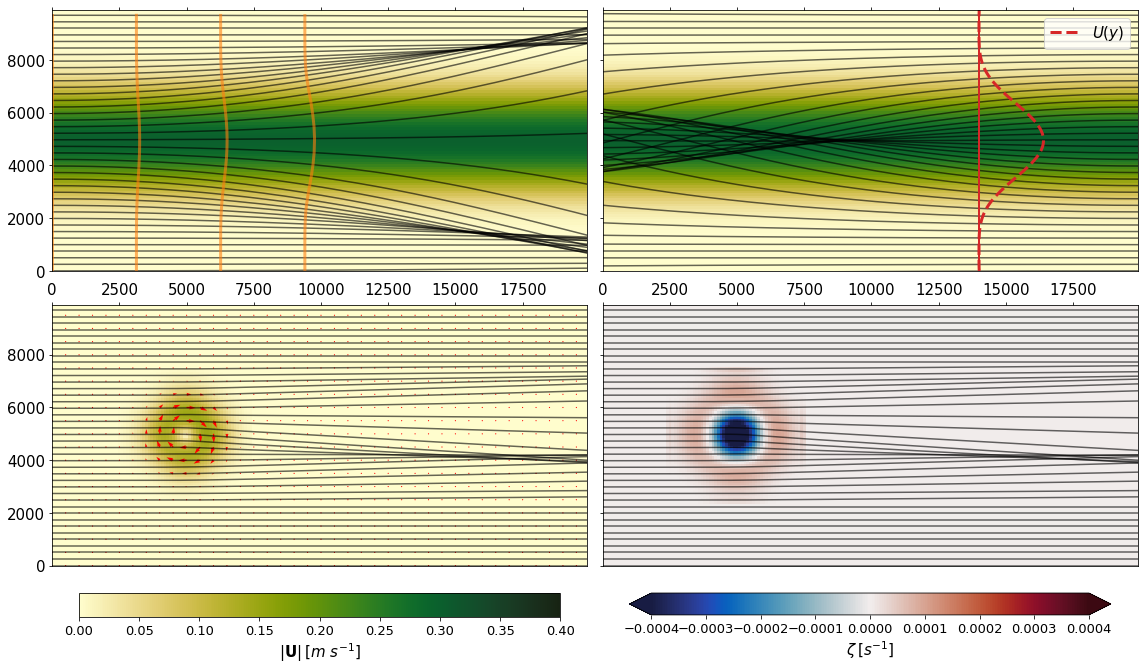

In [90]:
fig,ax = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(16,10),
                      )

cases = [ds_jet_left, ds_jet_right, wt_eddy, wt_eddy]
s_max = .4

pc=ax[0,0].pcolormesh(wt_jet.x,wt_jet.y,wt_jet.U[0,:,:],shading='auto',cmap=cmocean.cm.speed,vmin=0,vmax=s_max)

ax[0,1].pcolormesh(wt_jet.x,wt_jet.y,wt_jet.U[0,:,:],shading='auto',cmap=cmocean.cm.speed,vmin=0,vmax=s_max)



ax[1,0].pcolormesh(wt_eddy.x,wt_eddy.y,ncin.speed[idt0,:,:],shading='auto',cmap=cmocean.cm.speed,
                   vmin=0,vmax=s_max)

q_step = 5
qu=ax[1,0].quiver(wt_eddy.x[::q_step],wt_eddy.y[::q_step],
                  wt_eddy.U[0,::q_step,::q_step],wt_eddy.V[0,::q_step,::q_step],
                  color='r', scale=8)

pc2=ax[1,1].pcolormesh(wt_eddy.x,wt_eddy.y,vorticity[0,:,:],shading='auto',cmap=cmocean.cm.balance,vmin=-4e-4,vmax=4e-4)

#for i,aax in enumerate(ax.flatten()):
for i,aax in enumerate([ax[0,0],ax[0,1],ax[1,0],ax[1,1]]):
    wt =cases[i]
    for i in range(0,wt_eddy.nb_wave_rays,5):        
        aax.plot(wt.ray_x[i,:],wt.ray_y[i,:],'-k',alpha=0.6)
    aax.tick_params(labelsize=fs)
    aax.xaxis.tick_top()

ax[0,0].set_xlim([X0,XN])
ax[0,0].set_ylim([Y0,YN])

idts = np.arange(0,nt-140,40)
ax[0,0].plot(wt_jet.ray_x[::5,idts],wt_jet.ray_y[::5,idts],c='tab:orange',lw=3,alpha=0.6)

ax[0,1].plot(wt_jet.x[140]+wt_jet.U[0,:,10]*8000,wt_jet.y,lw=3, ls='--', c='tab:red',label=r'$U(y)$')
ax[0,1].plot(wt_jet.x[140]+wt_jet.U[0,:,10]*0,wt_jet.y,lw=2, ls='-', c='tab:red')
ax[0,1].legend(fontsize=fs,loc='upper right')

fig.tight_layout()

cb1=fig.colorbar(pc, ax=[ax[0,0],ax[1,0]], orientation='horizontal',shrink=0.9, pad=0.04)
cb2=fig.colorbar(pc2, ax=[ax[0,1],ax[1,1]], orientation='horizontal',shrink=0.9, extend='both', pad=0.04)
cb1.set_label(r'$|\mathbf{U}| \: [m~s^{-1}]$',fontsize=fs)
cb2.set_label(r'$\zeta \: [s^{-1}] $',fontsize=fs)
cb1.ax.tick_params(labelsize=fs-2) 
cb2.ax.tick_params(labelsize=fs-2) 

fig.savefig('current_refraction_examples.png',dpi=170)


# Depth refraction

In [93]:
# constant slope bottom
wt_cs = Wave_tracing(ncin.U_zero[idt0,:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy,nb_wave_rays=nb_wave_rays,
                        domain_X0=X0, domain_XN=XN,
                        domain_Y0=Y0, domain_YN=YN,
                        d=ncin.bathymetry_1dy_slope.data)
wt_cs.set_initial_condition( wave_period, 0, incoming_wave_side='left',)
wt_cs.solve()

In [102]:
# constant slope bottom lower right
wt_cs_lr = Wave_tracing(ncin.U_zero[idt0,:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy, nb_wave_rays=nb_wave_rays,
                        domain_X0=X0, domain_XN=XN,
                        domain_Y0=Y0, domain_YN=YN,
                        d=ncin.bathymetry_1dy_slope.data)
wt_cs_lr.set_initial_condition( wave_period,  np.linspace(np.pi/10,0.66*np.pi,nb_wave_rays),ipx=float(5000),ipy=float(2000),)
wt_cs_lr.solve()

In [95]:
# complex bottom left
wt_cb_l = Wave_tracing(ncin.U_zero[idt0,:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy, 
                        nb_wave_rays=nb_wave_rays,
                        domain_X0=X0, domain_XN=XN,
                        domain_Y0=Y0, domain_YN=YN,
                        d=ncin.bathymetry_bm.data)
wt_cb_l.set_initial_condition(wave_period, 0, incoming_wave_side='left')
wt_cb_l.solve()

In [96]:
# complex bottom bottom
wt_cb_b = Wave_tracing(ncin.U_zero[idt0,:,:], ncin.V_zero[idt0,:,:], nx, ny, nt,T,dx,dy,nb_wave_rays=nb_wave_rays,
                        domain_X0=X0, domain_XN=XN,
                        domain_Y0=Y0, domain_YN=YN,
                        d=ncin.bathymetry_bm.data)
wt_cb_b.set_initial_condition( wave_period, 1, incoming_wave_side='bottom',)
wt_cb_b.solve()

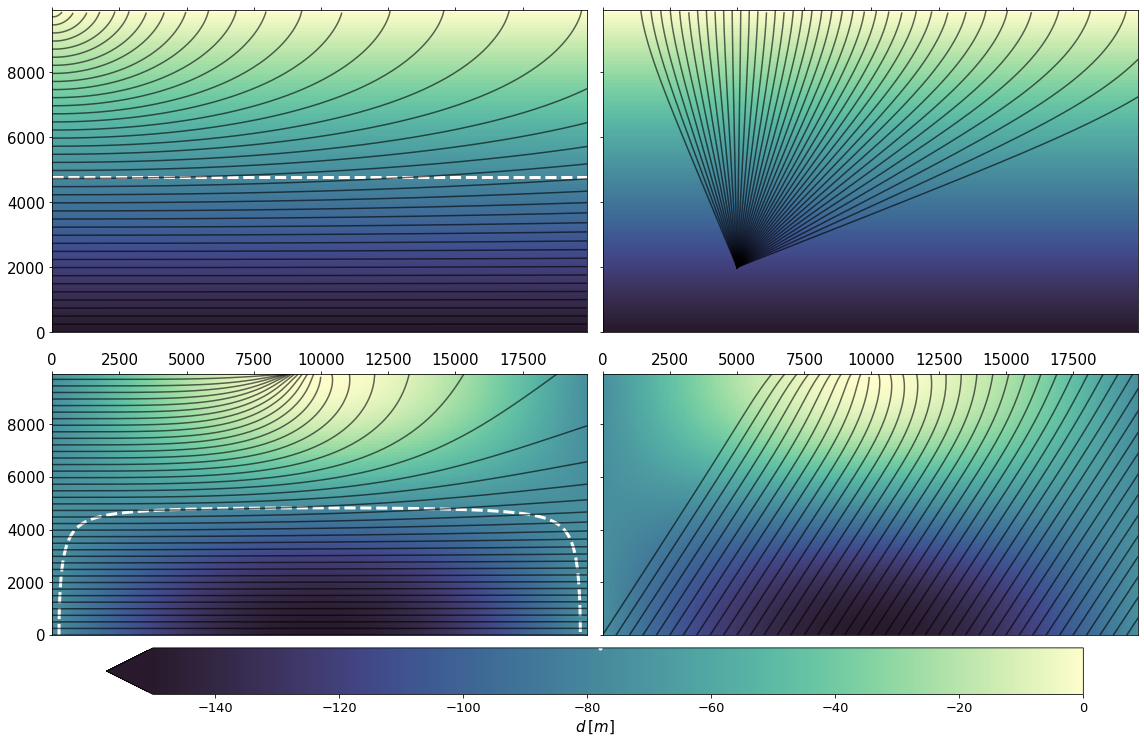

In [106]:
fig2,ax2 = plt.subplots(nrows=2,ncols=2,sharex=True,sharey=True,figsize=(16,10))

cases_b = [wt_cs, wt_cs_lr, wt_cb_l, wt_cb_b]
d_max = -150

pc_d=ax2[0,0].pcolormesh(wt_cs.x,wt_cs.y,-wt_cs.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=d_max,vmax=0)


ax2[0,1].pcolormesh(wt_cs_lr.x, wt_cs_lr.y,-wt_cs_lr.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=d_max,vmax=0)

ax2[1,0].pcolormesh(wt_cb_l.x, wt_cb_l.y,-wt_cb_l.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=d_max,vmax=0)

ax2[1,1].pcolormesh(wt_cb_l.x, wt_cb_l.y,-wt_cb_l.d[:,:],shading='auto',cmap=cmocean.cm.deep_r,vmin=d_max,vmax=0)


for i,aax in enumerate(ax2.flatten()):
    wt =cases_b[i]
    for i in range(0,wt.nb_wave_rays,5):
        aax.plot(wt.ray_x[i,:],wt.ray_y[i,:],'-k',alpha=0.6)
    aax.tick_params(labelsize=fs)
    aax.xaxis.tick_top()

ax2[0,0].set_xlim([X0,XN])
ax2[0,0].set_ylim([Y0,YN])

ax2[0,0].contour(wt_cs.x,wt_cs.y,-wt_cs.d[:,:],[-156/2], colors='w', linewidths=3 )
ax2[1,0].contour(wt_cb_l.x,wt_cb_l.y,-wt_cb_l.d[:,:],[-156/2], colors='w', linewidths=3 )


fig2.tight_layout()

cb1_d=fig2.colorbar(pc_d, ax=[ax2[1,0],ax2[1,1]], orientation='horizontal',shrink=0.9, pad=0.04, extend='min')

cb1_d.set_label(r'$d \: [m]$',fontsize=fs)

cb1_d.ax.tick_params(labelsize=fs-2) 
#cb1_d.ax.plot([1],[-156/2],'w')
#cb1_d.ax.plot([-40],[-0.5],'w')
cb1_d.ax.plot(-156/2,0.1, 'w.')

fig2.savefig('depth_refraction_examples.png',dpi=170)


# Comparing eddy with and without bathymetry

In [107]:
# EDDY
wt_eddy_b = Wave_tracing(ncin.U[idt0::,:,:], ncin.V[idt0::,:,:], nx, ny, nt,T,dx,dy,
                         nb_wave_rays=nb_wave_rays,
                         domain_X0=X0, domain_XN=XN,
                         domain_Y0=Y0, domain_YN=YN,
                          d=ncin.bathymetry_bm.data)
wt_eddy_b.set_initial_condition(wave_period, theta0,incoming_wave_side=i_w_side,)
wt_eddy_b.solve()

In [108]:
xx_eddy,yy_eddy,hm_eddy = wt_eddy.ray_density(5,5)
xx_eddy_b,yy_eddy_b,hm_eddy_b = wt_eddy_b.ray_density(5,5)

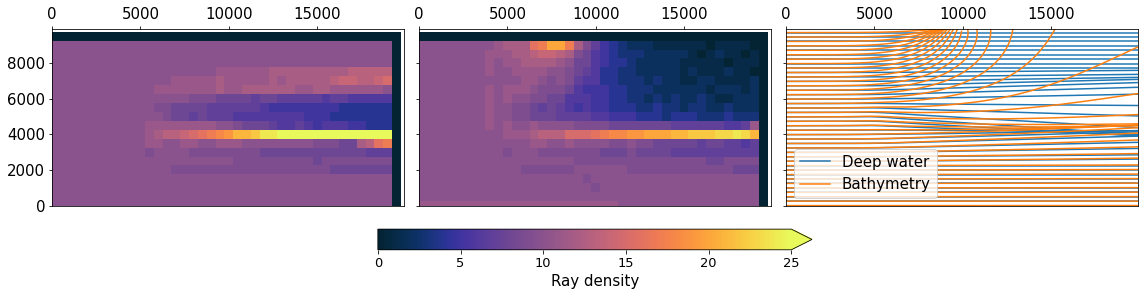

In [112]:
fig3, ax3 = plt.subplots(ncols=3,sharex=True,sharey=True,figsize=(16,4))


pc3 = ax3[0].pcolormesh(xx_eddy,yy_eddy, hm_eddy, vmin=0,vmax=25,shading='auto',cmap=cmocean.cm.thermal)
ax3[1].pcolormesh(xx_eddy_b,yy_eddy_b, hm_eddy_b, vmin=0,vmax=25,shading='auto',cmap=cmocean.cm.thermal)

for i in range(0,wt_eddy.nb_wave_rays,5):
    if i == 0:
        ax3[2].plot(wt_eddy.ray_x[i,:],wt_eddy.ray_y[i,:],c='tab:blue',alpha=1, label='Deep water')
    else:
        ax3[2].plot(wt_eddy.ray_x[i,:],wt_eddy.ray_y[i,:],c='tab:blue',alpha=1)
    
for i in range(0,wt_eddy_b.nb_wave_rays,5):
    if i ==0:
        ax3[2].plot(wt_eddy_b.ray_x[i,:],wt_eddy_b.ray_y[i,:],c='tab:orange',alpha=1, label='Bathymetry')
    else:
        ax3[2].plot(wt_eddy_b.ray_x[i,:],wt_eddy_b.ray_y[i,:],c='tab:orange',alpha=1)
ax3[2].legend(fontsize=fs,loc='lower left')
ax3[0].set_xlim([X0,XN])
ax3[0].set_ylim([Y0,YN])

for i,aax in enumerate(ax3):    
    aax.tick_params(labelsize=fs)
    aax.xaxis.tick_top()

fig3.tight_layout()


cb3=fig3.colorbar(pc3, ax=[ax3], orientation='horizontal',shrink=0.4, pad=0.10, extend='max')

cb3.set_label('Ray density',fontsize=fs)

cb3.ax.tick_params(labelsize=fs-2) 
fig3.savefig('depth_and_current_refraction.png',dpi=170)